<font size="+2" color="blue">Additional results: various ngram sizes</font>

# Practice Session 03: Find near-duplicates using shingling

In this session we will take a large corpus of tweets and detect near-duplicates on this corpus using a technique known as *shingling*.

Two documents are considered near-duplicates if they share a large amount of ngrams. The *ngrams* of a phrase are overlapping sequences of words of length *n*. For instance, the phrase '*There is no call we do not answer.*' has the following 3-grams:

* 'there is no'
* 'is no call'
* 'no call we'
* 'call we do'
* 'we do not'
* 'do not answer'

To measure the similarity between two sets, we will use the [Jaccard index](https://en.wikipedia.org/wiki/Jaccard_index), which is the size of the intersection of the two sets divided by their union. This values goes between 0.0 (meaning the documents have no ngrams in common) to 1.0 (meaning the documents have the same ngrams).

To speed up things, instead of comparing the set of shingles of two documents which can be large, we will derive a fixed-length *signature* or *sketch* for each document. This will be obtained by (1) applying a random permutation to the list of possible ngrams, and (2) pick the ngram that appears first in the permuted list. The Jaccard index between these signatures will be a good approximation of the Jaccard index between the original sets of ngrams.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

# 0. Dataset

The corpus you will use contains about 35,500 messages ("tweets") posted between March 13th, 2020, and March 14th, 2020, containing a hashtag or keyword related to COVID-19, and posted by a user declaring a location in Catalonia.

The tweets are in a format known as [JSON](https://en.wikipedia.org/wiki/JSON#Example). Python's JSON library takes care of translating it into a dictionary.

Then, the file is compressed using `gzip`, and can be compressed with the `gunzip` command, although we will read it in compressed form. The file is named `CovidLockdownCatalonia.json.gz`.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [ ]:
import io
import json
import gzip
import re
import random
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# KEEP AS-IS

# Input file
INPUT_FILENAME = "CovidLockdownCatalonia.json.gz"

# Array for storing messages
messages = []

# IMPORTANT:
# 1. Set this to 1000 during development
# 2. Set this to 10000 once you have completed the development, and answer part 5 with 10000
# 3. Set this back to 1000 for delivering your code
MAX_MESSAGES = 1000

with gzip.open(INPUT_FILENAME, "rt", encoding="utf-8") as input_file:

    messages_read = 0
    for line in input_file:

        # Read message
        tweet = json.loads(line)

        # Keep only messages in Catalan
        if tweet["lang"] == "ca":

            messages_read += 1

            if messages_read <= MAX_MESSAGES:
                author = tweet["user"]["screen_name"]
                message = tweet["full_text"]
                messages.append(message)

print("Read %d documents" % len(messages))

Read 1000 documents


# 1. Auxiliary functions

<font size="+1" color="red">Replace this cell with your code for function "jaccard_similarity"</font>

In [ ]:
def jaccard_similarity(set1,set2):
  set1, set2=set(set1), set(set2)
  union=len(set1.union(set2))
  return len(set1.intersection(set2))/union if union!=0 else 0

Write code to test your function. Your tests cases should be:

1. Two arrays for which the jaccard similarity is 0.5
1. Two arrays for which the jaccard similarity is 0.75
1. Two empty arrays should have jaccard similarity 0.0
1. Two arrays for which the jaccard similarity is 1.0

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

<font size="+1" color="red">Replace this cell with your code testing "jaccard_similarity"</font>

In [ ]:
test_cases = [
        ({"a", "b", "c"}, {"b", "c", "d"}),
        ({"a", "b", "c", "d"}, {"b", "c", "d"}),
        ({"a", "b"}, {"c", "d"}),
        ({"a", "b", "c"}, {"a", "b", "c"})
    ]

for i, (set1, set2) in enumerate(test_cases, 1):
    result = jaccard_similarity(set1, set2)
    print(f"Test {i} - We get: {result:.2f}")

Test 1 - We get: 0.50
Test 2 - We get: 0.75
Test 3 - We get: 0.00
Test 4 - We get: 1.00


<font size="+1" color="red">Replace this cell with your code for function "clean"</font>

In [ ]:
def clean(text):
    # 1. Delete "RT "
    text = re.sub(r'\bRT\b\s*', '', text).lower()

    # 3. Romanization
    text = text.replace('ñ', 'n')
    text = text.replace('ó', 'o').replace('ò', 'o').replace('ö', 'o')
    text = text.replace('à', 'a').replace('á', 'a').replace('ä', 'a')
    text = text.replace('è', 'e').replace('é', 'e').replace('ë', 'e')
    text = text.replace('ì', 'i').replace('í', 'i').replace('ï', 'i')
    text = text.replace('ù', 'u').replace('ú', 'u').replace('ü', 'u')
    text = text.replace('l·l', 'll')

    # 4. Remove URLs (http y https)
    text = re.sub(r'http[s]?://\S+', '', text)

    # 6. Remove very no letter or number
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # 7. Replace double space to one space
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

<font size="+1" color="red">Replace this cell with your code testing function "clean"</font>

In [ ]:
# Print results
for i in range(0,5):
    cleaned_text = clean(messages[i])
    print(f"Test {i}:")
    print(f"Original: {messages[i]}")
    print(f"Cleaned:  {cleaned_text}")
    print()

Test 0:
Original: RT @aramateix: La gestió del telèfon d'atenció 061 depèn de Ferrovial. La decisió del @govern NO modifica això. La gent no pagarà de manera…
Cleaned:  aramateix la gestio del telefon datencio 061 depen de ferrovial la decisio del govern no modifica aixo la gent no pagara de manera

Test 1:
Original: RT @Totbadalona: 🦠Els restaurants han de reduir el seu aforament en un 66% per garantir la seguretat davant del coronavirus #Badalona https…
Cleaned:  totbadalona els restaurants han de reduir el seu aforament en un 66 per garantir la seguretat davant del coronavirus badalona https

Test 2:
Original: RT @XSalaimartin: Fa temps que sabem que aquest tal Garcia-Page és un miserable. Però amb això se supera fins i tot a sí mateix. https://t.…
Cleaned:  xsalaimartin fa temps que sabem que aquest tal garciapage es un miserable pero amb aixo se supera fins i tot a si mateix

Test 3:
Original: RT @marctarinmarti: 2. La transmissió de la #COVID19 és per gotes. Per tant, raó de més 

# 2. Implement an n-gram extractor

<font size="+1" color="red">Replace this cell with your code implementing function "ngrams(text,size)"</font>

In [ ]:
MIN_TOKEN_LENGTH = 3

def ngrams(text, size):
    tokens = clean(text).split()
    ngrams = []
    # your code here
    list1=[i for i in tokens if len(i)>=MIN_TOKEN_LENGTH]
    for i in range(0,len(list1)-size+1):
        ngrams.append(" ".join(list1[i:i+size]))

    return ngrams

<font size="+1" color="red">Replace this cell with your code testing function "ngrams"</font>

In [ ]:
print(messages[990])
print(ngrams(messages[990], 3))

Clam per la suspensió dels desnonaments en plena crisi pel coronavirus https://t.co/0g1AtSELwl
['clam per suspensio', 'per suspensio dels', 'suspensio dels desnonaments', 'dels desnonaments plena', 'desnonaments plena crisi', 'plena crisi pel', 'crisi pel coronavirus']


# 3. Estimation of brute force all-pairs method

In [ ]:
# LEAVE AS-IS

def time_brute_force_similarities(messages, limit, ngram_size):
    if limit > len(messages):
        raise ValueError("Limit should be less than or equal than the number of messages")

    # Start a timer
    start = timer()

    # Iterate through document identifiers
    for docid1 in range(np.min([len(messages), limit])):

        # Clean document 1 and extract ngrams
        doc1 = clean(messages[docid1])
        ngrams1 = ngrams(doc1, ngram_size)

        # Iterate through document identifiers larger than doc2
        for docid2 in range(docid1+1, np.min([len(messages), limit])):

            # Clean document 2 and extract ngrams
            doc2 = clean(messages[docid2])
            ngrams2 = ngrams(doc2, ngram_size)

            # Compute similarity
            similarity = jaccard_similarity(ngrams1, ngrams2)

    end = timer()
    return(end - start)

<font size="+1" color="red">Replace this cell with your code for generating the requested plot. Remember to add a title and label for the x and y axis.</font>

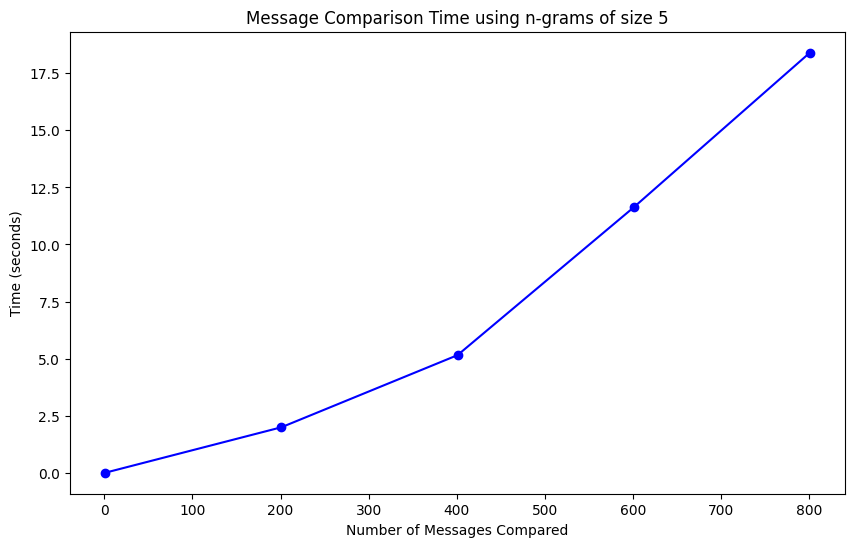

In [ ]:
x_values = range(1, 1001, 200)
y_values = [time_brute_force_similarities(messages, limit, 5) for limit in x_values]

plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')

# Labels and title
plt.title("Message Comparison Time using n-grams of size 5")
plt.xlabel("Number of Messages Compared")
plt.ylabel("Time (seconds)")
plt.show()

<font size="+1" color="red">Replace this cell with (1) a brief commmentary about what you see in this plot, and (2) your estimate for how long it would take to run the brute force similarity computations for the entire input matrix. Express your estimation in hours, minutes, and seconds. Justify precisely your calculations.</font>

### Commentary on the Plot:

1. **Linear Growth**:
   The curve suggests that the time complexity is quadratic, as both axes are linear, and the line slopes upwards steadily.

2. **Exponential Escalation**:
   After around 600 messages, the time increase becomes more significant, suggesting that larger datasets result in considerably more computational overhead as the number of comparisons grows.

---

### Estimation for the Full Input Matrix:

Given that it took approximately **23 seconds** to compare **800 messages**, we can estimate the time for the full input matrix based on a proportional extrapolation.

#### Formula to Estimate Total Time:
The brute force approach typically compares each document with every other document, so the number of comparisons for `n` messages is given by the formula for combinations: $ \frac {n(n+1)}{2}$


For 800 messages, we already know it took 23 seconds, so let’s extrapolate this time for the full dataset size.

---

#### Estimation Steps:

1. **Assume dataset size = 1000** (since the code mentions scanning documents up to `docid 1000`).
2. Total comparisons for 1000 messages:
   $ \frac{1000 \times 999}{2} = 499500 \text{ comparisons}$
3. Total comparisons for 800 messages:
   $\frac{800 \times 799}{2} = 319,600 \text{ comparisons}$
4. Time for 800 messages = **23 seconds**, so we use the ratio:
   $\frac{\text{Time for 1000 messages}}{\text{Time for 800 messages}} = \frac{499,500}{319,600}$
   $\text{Time for 1000 messages} = 23 \times \frac{499,500}{319,600} \approx 35.9 \text{ seconds}$

Then, it would take about **36 seconds**, **0.6 minuts** or **0.01 hours**  for the entire input matrix.



# 4. Computing the doc-ngram matrix

## 4.1 Create list of all ngrams

<font size="+1" color="red">Replace this cell with your code for creating the ngram_to_index dictionary.</font>

In [ ]:
NGRAM_SIZE = 4

ngram_to_index = {}
index_to_ngram = {}
next_index = 0

for message in messages:
    all_ngrams = ngrams(message, NGRAM_SIZE)

    for ngram in all_ngrams:
        # YOUR CODE HERE
        if ngram not in ngram_to_index:
            ngram_to_index[ngram] = next_index
            index_to_ngram[next_index] = ngram
            next_index += 1

num_distinct_ngrams = next_index
print("There are %d distinct ngrams in the %d documents" % (num_distinct_ngrams, len(messages)))

There are 8082 distinct ngrams in the 1000 documents


<font size="+1" color="red">Replace this cell with your code for testing the ngram_to_index structure.</font>

In [ ]:
test = ["els restaurants han reduir", "supera fins tot mateix"]

# Iterate over the test strings
for test_string in test:
    # Clean the test string and extract n-grams
    cleaned_string = clean(test_string)
    extracted_ngrams = ngrams(cleaned_string, NGRAM_SIZE)

    print(f"Testing string: '{test_string}'")

    for ngram in extracted_ngrams:
        index = ngram_to_index.get(ngram)

        if index is not None:
            # Print the n-gram and its corresponding index
            print(f"N-gram: '{ngram}' | Index: {index}")

            # Verify that index_to_ngram returns the same n-gram
            retrieved_ngram = index_to_ngram.get(index)
            assert retrieved_ngram == ngram, f"Error: Index {index} does not map back to '{ngram}'"
            print(f"Index {index} maps back to the same n-gram: '{retrieved_ngram}'")
        else:
            print(f"N-gram: '{ngram}' not found in ngram_to_index.")

    print()


Testing string: 'els restaurants han reduir'
N-gram: 'els restaurants han reduir' | Index: 14
Index 14 maps back to the same n-gram: 'els restaurants han reduir'

Testing string: 'supera fins tot mateix'
N-gram: 'supera fins tot mateix' | Index: 37
Index 37 maps back to the same n-gram: 'supera fins tot mateix'



## 2.2 Create table ngrams x documents

In [ ]:
# LEAVE AS-IS

# Create dense matrix in which every cell contains the value "False"
M_ngram_doc = np.full((num_distinct_ngrams, len(messages)), False)

# Print the number of rows and columns of this matrix
# numpy.matrix.shape is a tuple, shape[0] is the number of rows, shape[1] the number of columns
print("Matrix dimensions: %d rows (distinct shingles) x %d columns (distinct documents)" % M_ngram_doc.shape)

Matrix dimensions: 8082 rows (distinct shingles) x 1000 columns (distinct documents)


<font size="+1" color="red">Replace this cell with your code for filling the M_ngram_doc matrix.</font>

In [ ]:
# Size n-gram
ngram_size = NGRAM_SIZE

for docid in range(len(messages)):
    message = messages[docid]
    all_ngrams = ngrams(message, ngram_size)

    for ngram in all_ngrams:
        if ngram in ngram_to_index:
            index = ngram_to_index[ngram]
            M_ngram_doc[index, docid] = True

<font size="+1" color="red">Replace this cell with your code for printing the density of the M_ngram_doc matrix as a percentage. Use 4 decimals.</font>

In [ ]:
# Count number of True
non_zero_count = sum(sum(row) for row in M_ngram_doc)  # Sumar los valores True en cada fila

# Calculate the total size
total_cells = len(M_ngram_doc) * len(messages)

# Calculate the density percentage
density_percentage = (non_zero_count / total_cells) * 100

# Print the probability
print(f"Densidad de la matriz M_ngram_doc: {density_percentage:.4f}%")


Densidad de la matriz M_ngram_doc: 0.1395%


<font size="+1" color="red">Replace this cell with your code for printing rows 9602 and 941 of the M_ngram_doc matrix.</font>

In [ ]:
docids_to_print = [16, 941]

for docid in docids_to_print:
    print(f"\nPositions of non-zeros in column of docid {docid} of M_ngram_doc")

    # Get the clean message
    clean_message = clean(messages[docid])
    print(f"Clean message:\n {clean_message}")

    # Find n-grams no zero in the column
    non_zero_ngrams = []
    for ngram_index, row in enumerate(M_ngram_doc):
        if row[docid]:  # Find a true in that row
            # Find the n-gram using index_to_ngram
            ngram = index_to_ngram[ngram_index]
            non_zero_ngrams.append(f"{ngram_index} ({ngram})")

    # Print non zero n-grams
    print("Non-zeros in corresponding row:")
    print(non_zero_ngrams)


Positions of non-zeros in column of docid 16 of M_ngram_doc
Clean message:
 emergenciescat es demana a la ciutadania limitar al maxim i si es pot evitar desplaaments de cap de setmana tot el que sigui ma
Non-zeros in corresponding row:
['179 (emergenciescat demana ciutadania limitar)', '180 (demana ciutadania limitar maxim)', '181 (ciutadania limitar maxim pot)', '182 (limitar maxim pot evitar)', '183 (maxim pot evitar desplaaments)', '184 (pot evitar desplaaments cap)', '185 (evitar desplaaments cap setmana)', '186 (desplaaments cap setmana tot)', '187 (cap setmana tot que)', '188 (setmana tot que sigui)']

Positions of non-zeros in column of docid 941 of M_ngram_doc
Clean message:
 hospiolot usem de forma responsable els recursos sanitaris 061 urgencies per coronavirus i sanitaries 012 consultes general
Non-zeros in corresponding row:
['1067 (usem forma responsable els)', '1068 (forma responsable els recursos)', '1069 (responsable els recursos sanitaris)', '1070 (els recursos sanita

# 3. Implement a permutation generator

<font size="+1" color="red">Replace this cell with your code for "random_permutation"</font>

In [ ]:
import random

def random_permutation(k):
    # Create the array from 0 to k-1
    array = list(range(k))
    # Shuffle the array to create a random permutation
    random.shuffle(array)
    return array

In [ ]:
# LEAVE AS-IS

# Permute a list according to a permutation
def permuter(original_list, permutation):
    permuted_list = []
    for index in permutation:
        permuted_list.append(original_list[index])
    return permuted_list

# Code for testing permutations
original_list_1 = ["1 (test1)", "2 (test2)", "3 (test3)", "4 (test4)", "5 (test5)"]
original_list_2 = ["1 (alpha)", "2 (gamma)", "3 (beta)", "4 (delta)", "5 (epsilon)"]

print("Test one permutation:")
permutation_1 = random_permutation(5)
print(permuter(original_list_1, permutation_1))
print(permuter(original_list_2, permutation_1))

print()

print("Test another permutation")
permutation_2 = random_permutation(5)
print(permuter(original_list_1, permutation_2))
print(permuter(original_list_2, permutation_2))

Test one permutation:
['5 (test5)', '3 (test3)', '2 (test2)', '4 (test4)', '1 (test1)']
['5 (epsilon)', '3 (beta)', '2 (gamma)', '4 (delta)', '1 (alpha)']

Test another permutation
['3 (test3)', '2 (test2)', '4 (test4)', '1 (test1)', '5 (test5)']
['3 (beta)', '2 (gamma)', '4 (delta)', '1 (alpha)', '5 (epsilon)']


# 4. Compute the signature of each document

In [ ]:
# Leave this code as-is

NUM_PERMUTATIONS = 5

permutations = []

# Create the permutations
for i in range(NUM_PERMUTATIONS):
    permutation = random_permutation(num_distinct_ngrams)
    permutations.append(random_permutation(num_distinct_ngrams))

# Visualize the permutations by printing their first 4 elements
for i in range(len(permutations)):
    permutation = permutations[i]
    print("Permutation %d: %d, %d, %d, %d, ..." % (i,
                permutation[0], permutation[1], permutation[2], permutation[3] ))

Permutation 0: 7996, 5385, 2168, 1242, ...
Permutation 1: 5, 5314, 2355, 847, ...
Permutation 2: 1112, 5380, 7509, 2605, ...
Permutation 3: 3023, 2420, 7173, 2962, ...
Permutation 4: 6510, 602, 6886, 1517, ...


In [ ]:
# LEAVE AS-IS

# Find the first ngram in a document, according to a permutation
def find_first_one(docid, permutation):
    for shingle_id in permutation:
        if M_ngram_doc[shingle_id, docid] == True:
            return shingle_id
    return -1

<font size="+1" color="red">Replace this cell with your code for creating M_signature_doc</font>

In [ ]:
M_signature_doc = np.full((NUM_PERMUTATIONS, len(messages)), np.nan)

# Create permutations
for permutation_num in range(NUM_PERMUTATIONS):
    print("Creating signatures for permutation %d/%d" % (permutation_num+1, NUM_PERMUTATIONS))
    permutation = permutations[permutation_num]
    for docid in range(len(messages)):
        if docid % 1000 == 0:
            print("- Scanning document %d of %d" % (docid, len(messages)))
        # replace this comment with your code
        # Find the first n-gram according to the permutation
        first_ngram = find_first_one(docid, permutation)

        # Store the result in the signature matrix
        M_signature_doc[permutation_num, docid] = first_ngram

Creating signatures for permutation 1/5
- Scanning document 0 of 1000
Creating signatures for permutation 2/5
- Scanning document 0 of 1000
Creating signatures for permutation 3/5
- Scanning document 0 of 1000
Creating signatures for permutation 4/5
- Scanning document 0 of 1000
Creating signatures for permutation 5/5
- Scanning document 0 of 1000


In [ ]:
# Leave this code as-is

def extract_ngrams(docid):
    return [x for x in range(num_distinct_ngrams) if M_ngram_doc[x, docid] == True]

def extract_signature(docid):
    return [M_signature_doc[x, docid] for x in range(NUM_PERMUTATIONS)]

def print_sig(messages, M_ngram_doc, M_signature_doc, i):
    print("Document #%d" % i)
    print("Message       : %s" % messages[i])
    print("Clean message : %s" % clean(messages[i]))
    print("Ngrams        : %s" % extract_ngrams(i))
    print("Signature     : %s" % extract_signature(i))

# Print two messages and their signatures

print_sig(messages, M_ngram_doc, M_signature_doc, 21 )
print()
print_sig(messages, M_ngram_doc, M_signature_doc, 24 )

Document #21
Message       : El problema és económic... ja no és només que primi lo económic a lo personal, és que fins i tot en això el @govern s'equivoca, doncs al final la factura que s'haurà de pagar serà més gran.... ja és més gran del que hauria sigut de fer les coses bé i a temps. https://t.co/jFXHAMZHO0
Clean message : el problema es economic ja no es nomes que primi lo economic a lo personal es que fins i tot en aixo el govern sequivoca doncs al final la factura que shaura de pagar sera mes gran ja es mes gran del que hauria sigut de fer les coses be i a temps
Ngrams        : [232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260]
Signature     : [258.0, 243.0, 254.0, 257.0, 235.0]

Document #24
Message       : RT @QuimTorraiPla: Seguiu les recomanacions: eviteu qualsevol desplaçament al màxim
Clean message : quimtorraipla seguiu les recomanacions eviteu qualsevol desplaament al maxim
Ngr

# 5. Compare all pairs of signatures

<font size="+1" color="red">Replace this cell with your code for comparing all signatures; print all documents that have at least X signature matches, considering both full matches and partial matches. X should be 0.5% of the  number of documents.</font>

In [ ]:
is_possible_duplicate = {}
dict_full={}
dict_partial={}
for docid in range(len(messages)):
    dict_full[docid] = []
    dict_partial[docid] = []

X = int(0.005 * len(messages))

# Iterate through all documents
for docid1 in range(len(messages)):

    # Do not examine again a document that is a possible duplicate
    if docid1 not in is_possible_duplicate:

        # Counters for full and partial signature matches
        count_sig_full_matches = 0
        count_sig_partial_matches = 0

        # Extract the signature of the doc1
        signature1 = extract_signature(docid1)
        if docid1 % 500 == 0:
            print("%d/%d documents scanned" % (docid1, len(messages)))

        # Iterate through documents with docid larger than doc1
        for docid2 in range(docid1 + 1, len(messages)):

            # If this has not already been marked as duplicate of another document
            if docid2 not in is_possible_duplicate:

                # Extract the signature of the doc2
                signature2 = extract_signature(docid2)

                # Calculate the jaccard similarity
                similarity = jaccard_similarity(signature1, signature2)

                # Verify the type of match
                if similarity == 1.0:
                    count_sig_full_matches += 1
                    is_possible_duplicate[docid2] = True
                    dict_full[docid1].append(docid2)
                elif 0.2 < similarity < 1.0:
                    count_sig_partial_matches += 1
                    dict_partial[docid1].append(docid2)
        # Print the document
        if count_sig_full_matches + count_sig_partial_matches >= X:
          print(f"Document {docid1}: {count_sig_full_matches} full matches, {count_sig_partial_matches} partial matches")
          print(messages[docid1])
          print()


0/10000 documents scanned
Document 16: 71 full matches, 1 partial matches
RT @emergenciescat: ⚠️ Es demana a la ciutadania limitar al màxim i, si es pot, EVITAR DESPLAÇAMENTS de cap de setmana. Tot el que sigui ma…

Document 19: 11 full matches, 51 partial matches
RT @emergenciescat: El comitè tècnic del Pla #PROCICAT  per evitar la propagació del #coronavirus ha proposat al Govern que ordeni el cessa…

Document 20: 28 full matches, 29 partial matches
RT @salutcat: Quines mesures de prevenció cal seguir per evitar la propagació del 🦠 #coronavirus SARS-CoV-2 👇

🔗 https://t.co/NS41dWDi9O ht…

Document 53: 57 full matches, 0 partial matches
RT @Oriol_Pintos: Sóc advocat laboralista. Davant aquesta situació d'incertesa jurídica generalitzada pel #Coronavirus que afecta i afectar…

Document 83: 119 full matches, 0 partial matches
RT @MainatJM: Imbècil total...

Document 166: 56 full matches, 0 partial matches
RT @yeyaboya: Les imatges de cues de cotxes sortint de Madrid són demencials. Quin

<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of complete matches, but few partial matches. Include the full text of the original tweet. Comment on why you believe this tweet is not being changed much when copied or re-tweeted.</font>

One tweet of high number of full matches is:

**Original Tweet:**

RT @MainatJM: Imbècil total...

**Results:**

Full Matches: 119

Partial Matches: 0

This tweet has generated a significant number of complete matches when retweeted. The main reason it shows no partial matches could be attributed to its concise and impactful sentence. As an expression of discontent or criticism, users likely retained the original text without modifications. Additionally, short tweets with a clear message tend to be more susceptible to being copied and pasted as is.



<font size="+1" color="red">Replace this cell with a brief commentary, based on the results above, about one tweet that has a substantial number of partial matches, but fewer complete matches. Include the full text of the original tweet and one near duplicate (that cannot be identical to the original tweet).</font>

One tweet that has a big number of partial matches but fewer complete matches is:

**Original Tweet:**

RT @emergenciescat: El comitè tècnic del Pla #PROCICAT per evitar la propagació del #coronavirus ha proposat al Govern que ordeni el cessa…

**Results:**

Full Matches: 11

Partial Matches: 51


This tweet has a considerable number of partial matches, indicating that while many users are retweeting the message, they are also making slight modifications. The presence of only 11 full matches suggests that the content is being adapted to fit different contexts or personal styles/opinions.

If we use the code ```messages[dict_partial[19][0]] ``` where 19 is ocid of original tweet, we get this near duplicate:

RT @salutcat: Quines mesures de prevenció cal seguir per evitar la propagació del 🦠 #coronavirus SARS-CoV-2 👇

🔗 https://t.co/NS41dWDi9O ht…

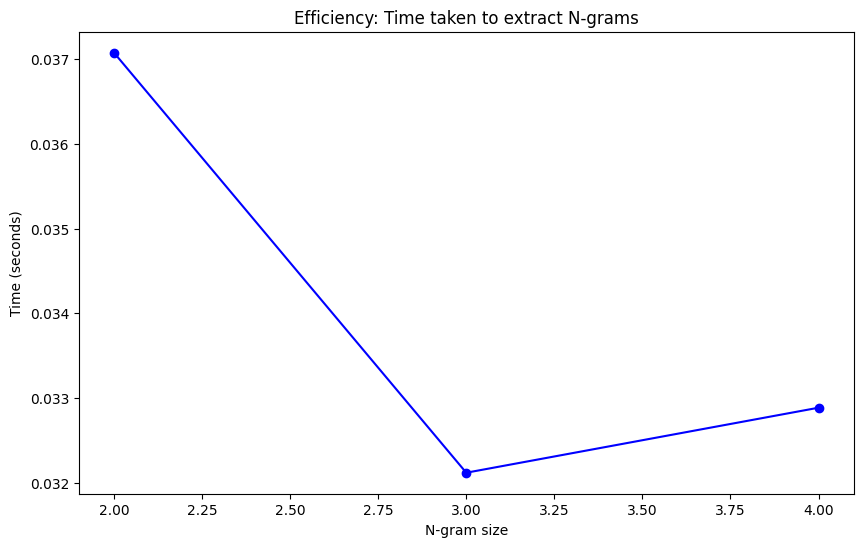

Accuracy:
2-grams: 0.0028
3-grams: 0.0016
4-grams: 0.0015


In [ ]:
import time
import matplotlib.pyplot as plt
import time
import matplotlib.pyplot as plt

# Compare sizes of n-grams
def compare_ngram_sizes(texts, sizes):
    time_results = {}
    ngram_results = {}

    for size in sizes:
        start_time = time.time()

        ngram_results[size] = [ngrams(text, size) for text in texts]

        end_time = time.time()
        time_results[size] = end_time - start_time

    return time_results, ngram_results

# Execute the comparition for n-grams of size 2, 3 y 4
ngram_sizes = [2, 3, 4]
time_results, ngram_results = compare_ngram_sizes(messages, ngram_sizes)

plt.figure(figsize=(10,6))
plt.plot(time_results.keys(), time_results.values(), marker='o', linestyle='-', color='b')
plt.xlabel('N-gram size')
plt.ylabel('Time (seconds)')
plt.title('Efficiency: Time taken to extract N-grams')
plt.show()


def compare_accuracy(ngram_results):
    accuracy_results = {}

    for size, ngram_lists in ngram_results.items():
        similarities = []
        # Compare every text
        for i in range(len(ngram_lists)):
            for j in range(i + 1, len(ngram_lists)):
                similarity = jaccard_similarity(ngram_lists[i], ngram_lists[j])
                similarities.append(similarity)
        # Calculate average jaccard similarity
        accuracy_results[size] = sum(similarities) / len(similarities) if similarities else 0

    return accuracy_results

accuracy_results = compare_accuracy(ngram_results)

# Print the results
print("Accuracy:")
for size, accuracy in accuracy_results.items():
    print(f"{size}-grams: {accuracy:.4f}")

**Efficiency:**
We can see 3-gram and 4-gram are faster than 2-gram. It makes sense because 2-gram has to do more combinations of 2 words. Meanwhile there are not so many mixed words with 4-gram to calculate. When n-gram size increases, there are not available so many word combinations than a small n-gram size.

**Accuracy:**´
We can see 4-grams is more efectiveness than 2 and 3-grams size because of number of grams

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>